<h1>Final Project</h1>

Signature $\left(-,+,+,+\right)$

In [1]:
import dill
dill.settings['recurse'] = True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def affine_connections(coords,g_uv,cache={}):
    if cache.get('inv_g_uv','empty') == 'empty':
        inv_g_uv = g_uv.inv()
        cache['inv_g_uv'] = inv_g_uv
    else:
        inv_g_uv = cache['inv_g_uv']
    ac = [sym.Matrix([[0,0,0,0] for n in range(4)]) for k in range(4)]
    for sigma in tqdm(range(4),desc="affine connections",leave=False):
        for lamb in tqdm(range(4),leave=False):
            for mu in tqdm(range(4),leave=False):
                for nu in tqdm(range(4),leave=False):
                    ac[sigma][lamb,mu] += sym.Rational(1,2)\
                    *inv_g_uv[nu,sigma]*(sym.diff(g_uv[mu,nu], coords[lamb])\
                    +sym.diff(g_uv[lamb,nu],coords[mu])\
                    -sym.diff(g_uv[mu,lamb],coords[nu]))
    cache['christoffels'] = ac
    return ac, cache

def ricci_tensor(coords,g_uv,cache={}):
    if cache.get('christoffels','empty') == 'empty':
        christoffels, cache = affine_connections(coords,g_uv,cache)
        cache['christoffels'] = christoffels
    else:
        christoffels = cache['christoffels']
    rt = sym.Matrix([[0,0,0,0] for n in range(4)])
    for mu in tqdm(range(4),desc="ricci tensor",leave=False):
        for kappa in tqdm(range(4),leave=False):
            for lamb in tqdm(range(4),leave=False):
                rt[mu,kappa] += sym.diff(christoffels[lamb][mu,kappa],coords[lamb])\
                -sym.diff(christoffels[lamb][kappa,lamb],coords[mu])
                for nu in tqdm(range(4),leave=False):
                    rt[mu,kappa] += christoffels[lamb][lamb,nu]*christoffels[nu][mu,kappa]\
                    -christoffels[lamb][mu,nu]*christoffels[nu][lamb,kappa]
    cache['ricci_tensor'] = rt
    return rt, cache

def ricci_scalar(coords,g_uv,cache={}):
    if cache.get('ricci_tensor','empty'):
        rt, cache = ricci_tensor(coords,g_uv,cache)
        cache['ricci_tensor'] = rt
    else:
        rt = cache['ricci_tensor']
    inv_g_uv = cache['inv_g_uv']
    scalar = sym.Symbol('scalar')
    scalar = 0
    for mu in tqdm(range(4),leave=False,desc='ricci scalar'):
        for nu in tqdm(range(4),leave=False):
            scalar += inv_g_uv[mu,nu]*rt[mu,nu]
    cache['ricci_scalar'] = scalar 
    return scalar, cache

def einstein_tensor(coords,g_uv,cache={}):
    if cache.get('inv_g_uv','empty') == 'empty':
        inv_g_uv = g_uv.inv()
        cache['inv_g_uv'] = inv_g_uv
    else:
        inv_g_uv = cache['inv_g_uv']
    if cache.get('christoffels','empty') == 'empty':
        christoffels, cache = affine_connections(coords,g_uv,cache)
        cache['christoffels'] = christoffels
    else:
        christoffels = cache['christoffels']
    if cache.get('ricci_tensor','empty') == 'empty':
        rt, cache = ricci_tensor(coords,g_uv,cache)
        cache['ricci_tensor'] = rt
    else:
        rt = cache['ricci_tensor']
    if cache.get('ricci_scalar','empty') == 'empty':
        rs, cache = ricci_scalar(coords,g_uv,cache)
        cache['ricci_scalar'] = rs
    else:
        rs = cache['ricci_scalar']
    cache['einstein_tensor'] = rt - sym.Rational(1,2)*rs*g_uv
    return cache['einstein_tensor'], cache

def affine_connections_functions(coords,g_uv,cache={}):
    params = cache['params']
    if cache.get('inv_g_uv','empty') == 'empty':
        inv_g_uv = g_uv.inv()
        cache['inv_g_uv'] = inv_g_uv
    else:
        inv_g_uv = cache['inv_g_uv']
    ac = [sym.Matrix([[0,0,0,0] for n in range(4)]) for k in range(4)]
    for sigma in tqdm(range(4),desc="affine connections",leave=False):
        for lamb in tqdm(range(4),leave=False):
            for mu in tqdm(range(4),leave=False):
                for nu in tqdm(range(4),leave=False):
                    ac[sigma][lamb,mu] += sym.Rational(1,2)\
                    *inv_g_uv[nu,sigma]*(sym.diff(g_uv[mu,nu], coords[lamb])\
                    +sym.diff(g_uv[lamb,nu],coords[mu])\
                    -sym.diff(g_uv[mu,lamb],coords[nu]))
        ac[sigma] = sym.lambdify(coords+params,ac[sigma],"numpy")
    return ac

def affine_connections_diff_functions(coords,g_uv,cache={}):
    params = cache['params']
    if cache.get('inv_g_uv','empty') == 'empty':
        inv_g_uv = g_uv.inv()
        cache['inv_g_uv'] = inv_g_uv
    else:
        inv_g_uv = cache['inv_g_uv']
    if cache.get('christoffels','empty') == 'empty':
        christoffels, cache = affine_connections(coords,g_uv,cache)
        cache['christoffels'] = christoffels
    else:
        christoffels = cache['christoffels']
    acd = [[sym.Matrix([[0,0,0,0] for l in range(4)]) for m in range(4)] for n in range(4)]
    for nu in tqdm(range(4),desc="affine connections derivatives",leave=False):
        for mu in tqdm(range(4),leave=False):
            acd[mu][nu] = sym.lambdify(coords+params,sym.diff(christoffels[mu],coords[nu]),"numpy")
    return acd

def ricci_tensor_functions(coords,g_uv,cache={}):
    params = cache['params']
    if cache.get('christoffels','empty') == 'empty':
        christoffels, cache = affine_connections(coords,g_uv,cache)
        cache['christoffels'] = christoffels
    else:
        christoffels = cache['christoffels']
    rt = sym.Matrix([[0,0,0,0] for n in range(4)])
    for mu in tqdm(range(4),desc="ricci tensor",leave=False):
        for kappa in tqdm(range(4),leave=False):
            for lamb in tqdm(range(4),leave=False):
                rt[mu,kappa] += sym.diff(christoffels[lamb][mu,kappa],coords[lamb])\
                -sym.diff(christoffels[lamb][kappa,lamb],coords[mu])
                for nu in tqdm(range(4),leave=False):
                    rt[mu,kappa] += christoffels[lamb][lamb,nu]*christoffels[nu][mu,kappa]\
                    -christoffels[lamb][mu,nu]*christoffels[nu][lamb,kappa]
    cache['ricci_tensor'] = rt
    for nu in tqdm(range(4),desc='ricci tensor functions',leave=False):
        for mu in tqdm(range(4),leave=False):
            g = sym.lambdify(coords+params,rt[nu,mu],"numpy")
            file = open( "R_"+str(nu)+str(mu)+".p", "wb" ) 
            dill.dump(g, file)
            file.close()
    return rt

def ricci_tensor_function(point, params, cache={}):
    rt = sym.Matrix([[0,0,0,0] for n in range(4)])
    for nu in range(4):
        for mu in range(4):
            if cache.get("R_"+str(nu)+str(mu),"empty") == "empty":
                g = dill.load(open("R_"+str(nu)+str(mu)+".p","rb"))
                cache["R_"+str(nu)+str(mu)] = g
            else:
                g = cache["R_"+str(nu)+str(mu)]
            rt[nu,mu] = g(*(point+params))
    return rt, cache

def einstein_tensor_functions(coords,g_uv,cache={}):
    params = cache['params']
    if cache.get('inv_g_uv','empty') == 'empty':
        inv_g_uv = g_uv.inv()
        cache['inv_g_uv'] = inv_g_uv
    else:
        inv_g_uv = cache['inv_g_uv']
    if cache.get('christoffels','empty') == 'empty':
        christoffels, cache = affine_connections(coords,g_uv,cache)
        cache['christoffels'] = christoffels
    else:
        christoffels = cache['christoffels']
    if cache.get('ricci_tensor','empty') == 'empty':
        rt, cache = ricci_tensor(coords,g_uv,cache)
        cache['ricci_tensor'] = rt
    else:
        rt = cache['ricci_tensor']
    if cache.get('ricci_scalar','empty') == 'empty':
        rs, cache = ricci_scalar(coords,g_uv,cache)
        cache['ricci_scalar'] = rs
    else:
        rs = cache['ricci_scalar']
    et = rt - sym.Rational(1,2)*rs*g_uv
    cache['einstein_tensor'] = et
    for nu in tqdm(range(4),desc='einstein tensor functions',leave=False):
        for mu in tqdm(range(4),leave=False):
            g = sym.lambdify(coords+params,et[nu,mu],"numpy")
            file = open( "E_"+str(nu)+str(mu)+".p", "wb" ) 
            dill.dump(g, file)
            file.close()
    return et, cache

<h1>Finding Metric</h1>

$ds^2 = -\left(1 - \frac{2M}{r}\right)dt^2 + \left(1 - \frac{2M}{r}\right)^{-1}dr^2 + r^2 d\theta^2 +r^2 \sin(\theta)^2 d\phi^2$ (sphereical)

$ds^2 = -\left(1 - \frac{2M}{r}\right)dt^2 + \left(1 - \frac{2M}{r}\right)^{-1}dr^2 + r^2 d\theta^2 + r^2 \sin(\theta)^2 d\phi^2$<br><br>
$ds^2 = -\left(1 - \frac{2M}{r}\right)dt^2 + \frac{2M}{r}\left(1 - \frac{2M}{r}\right)^{-1}dr^2 +dr^2+ r^2 d\theta^2 + r^2 \sin(\theta)^2 d\phi^2$<br><br>
$ r = \sqrt{\rho^2 + z^2}$<br><br>
$dr = \frac{\rho d\rho}{\sqrt{\rho^2 + z^2}}+\frac{z dz}{\sqrt{\rho^2 + z^2}}$<br><br>
$ds^2 = -\left(1 - \frac{2M}{\sqrt{\rho^2+z^2}}\right)dt^2 + \frac{2M}{\sqrt{\rho^2+z^2}}\left(1 - \frac{2M}{\sqrt{\rho^2+z^2}}\right)^{-1}\left(\frac{\rho d\rho}{\sqrt{\rho^2+z^2}}+\frac{z dz}{\sqrt{\rho^2+z^2}}\right)^2 + d\rho^2 + \rho^2 d\phi^2 + dz^2$ (cylindrical)

Lorentz Transformation (will be taken close to the speed of light)<br><br>
$z = \gamma \left(z' - v t'\right)$<br>
$t = \gamma \left( t' - v z' \right)$<br>
$-dt^2 + dz^2 = -dt'^2 + dz'^2$<br>
$M = \frac{E}{ \gamma}$<br>
$v \to 1$<br>
$\frac{\rho}{\sqrt{\rho^2+z^2}} \to 0$<br>
$ds^2 = -\left(1 - \frac{2M}{\sqrt{\rho^2+z^2}}\right)dt^2 + \left(\frac{2 M}{\sqrt{z^2 + \rho^2}}\right)\left(1 - \frac{2M}{\sqrt{\rho^2 + z^2}}\right)^{-1}\left(\frac{\rho d\rho}{\sqrt{z^2 + \rho^2}}+\frac{z dz}{\sqrt{z^2+\rho^2}}\right)^2 + dz^2 + d\rho^2 + \rho^2 d\phi^2$
$ds^2 = -\left(1 - \frac{2 E}{\gamma\sqrt{\rho^2+\gamma^2\left(z'-v t'\right)^2}}\right)\gamma^2\left(dt' -v dz'\right)^2 + \left(\frac{2 E}{\gamma \left(\rho^2 + \gamma^2 \left(z'- v t'\right)^2\right)}\right)\left(1 - \frac{2 E}{\gamma\sqrt{\rho^2 + \gamma^2\left(z'-v t'\right)^2}}\right)^{-1}\left( \rho d\rho + \gamma^2\left(z' - v t'\right)\left(dz'-v dt'\right)\right)^2 + d\rho^2 + \rho^2 d\phi^2 + \gamma \left(dz' - v dt'\right)$<br>
$ds^2 = -dt'^2 + dz'^2 + \rho^2 d \phi + d\rho^2 + \frac{2 E}{\mid z'-t'\mid}\left(dt'-dz'\right)^2$, $z' \neq t'$<br>

$ds^2 = -dt'^2 + dz'^2 + \rho^2 d \phi + d\rho^2 + \frac{2 E}{\mid z'-t'\mid}\left(dt'-dz'\right)^2+ \frac{2 E}{\mid z'+t'\mid}\left(dt'+dz'\right)^2$, $z' \neq t'$ (double photon)

Coordinate Change<br>
$\frac{1}{\sqrt{\rho^2+z^2}} = \frac{1}{2 \sqrt{\rho'^2+z_+^2}} + \frac{1}{ 2 \sqrt{\rho'^2+z_-^2}} = \omega\left(t',z',\rho'\right)$<br>
$-dt^2 + dz^2 = -dt'^2 + dz'^2$<br>
$p = p'$<br>
$z_- = \gamma\left(z' + v t'\right)$<br>
$t_- = \gamma\left(t' + v z'\right)$<br>
$z_+ = \gamma\left(z' - v t'\right)$<br>
$t_+ = \gamma\left(t' - v z'\right)$<br>
$\frac{1}{2}\left(z^2 + \rho^2\right) = \frac{1}{2}\left(\frac{1}{\sqrt{\rho'^2+z_+^2}} + \frac{1}{\sqrt{\rho'^2+z_-^2}}\right)^{-2} = \zeta \left(t',z',\rho'\right)$<br>
$ds^2 = 
-\left(1 - \frac{E}{\gamma\sqrt{\rho'^2+z_+^2}} - \frac{E}{\gamma\sqrt{\rho'^2+z_-^2}}\right)\left(dt'^2 - dz'^2 + \left( dt' \frac{\partial z}{\partial t'} + dz'\frac{\partial z}{\partial z'} + d\rho' \frac{\partial z}{\partial \rho'}\right)^2 \right)+ \frac{E}{\gamma}\left(1 - \frac{E}{\gamma\sqrt{\rho'^2+z_+^2}} - \frac{E}{
\gamma\sqrt{\rho'^2+z_-^2}}\right)^{-1}\left( \frac{1}{\sqrt{\rho^2+z_+^2}} + \frac{1}{\sqrt{\rho^2+z_-^2}}\right)\left(dt' \frac{\partial \zeta}{\partial t'}+dz' \frac{\partial \zeta}{\partial z'} + d\rho'\frac{\partial \zeta}{\partial \rho'}\right)^2+ d\rho'^2 + \rho'^2 d\phi'^2+\left(\frac{\partial z}{\partial t'} dt'+\frac{\partial z}{\partial z'} dz'+\frac{\partial z}{\partial \rho'} d \rho'\right)^2$<br>
$ds^2 = -\left(1 -  \frac{2 E}{\gamma} \omega\left(t',z',\rho'\right)\right)\left(dt'^2 - dz'^2 + \left( dt' \frac{\partial z}{\partial t'} + dz'\frac{\partial z}{\partial z'} + d\rho' \frac{\partial z}{\partial \rho'}\right)^2 \right)+
\frac{2 E}{\gamma}\left(1 - \frac{2 E}{\gamma} \omega\left('t,'z,\rho'\right)\right)^{-1} \omega\left(t', z', \rho'\right)\left(dt' \frac{\partial \zeta}{\partial t'}+dz' \frac{\partial \zeta}{\partial z'} + d\rho'\frac{\partial \zeta}{\partial \rho'}\right)^2+ d\rho'^2 + \rho'^2 d\phi'^2+\left(\frac{\partial z}{\partial t'} dt'+\frac{\partial z}{\partial z'} dz'+\frac{\partial z}{\partial \rho'} d \rho'\right)^2$

<h1>Metric in Python</h1>

In [3]:
t0, z0, rho0, phi, E, gamma, v, omega, zeta = sym.symbols('t0 z0 rho0, phi0 E gamma v omega zeta')
dt0sqr, dz0, drho0, dphi0 = sym.symbols('dt0 dz0 drho0 dphi0')
t, z, rho, phi, E, gamma, v, omega, zeta = sym.symbols('t z rho, phi E gamma v omega zeta')
dt, dz, drho, dphi = sym.symbols('dt dz drho dphi')
alpha, beta, Ef = sym.symbols('alpha beta Ef')

omega = 1/sym.sqrt(rho**2+gamma**2*(z+v*t)**2)/2+1/sym.sqrt(rho**2+gamma**2*(z-v*t)**2)/2
zeta = sym.Rational(1,2)*omega**(-2)

ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)

g_00 = ds2.subs(dz,0).subs(drho,0).subs(dphi,0).subs(dt,1)
g_11 = ds2.subs(dt,0).subs(dz,0).subs(dphi,0).subs(drho,1)
g_10 = sym.Rational(1,2)*(ds2.subs(dz,0).subs(dphi,0).subs(dt,1).subs(drho,1)-g_00-g_11)
g_01 = sym.Rational(1,2)*(ds2.subs(dz,0).subs(dphi,0).subs(dt,1).subs(drho,1)-g_00-g_11)
g_22 = ds2.subs(dt,0).subs(dz,0).subs(drho,0).subs(dphi,1)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_30 = sym.Rational(1,2)*(ds2.subs(drho,0).subs(dphi,0).subs(dt,1).subs(dz,1)-g_00-g_33)
g_03 = sym.Rational(1,2)*(ds2.subs(drho,0).subs(dphi,0).subs(dt,1).subs(dz,1)-g_00-g_33)
g_31 = sym.Rational(1,2)*(ds2.subs(dt,0).subs(dphi,0).subs(drho,1).subs(dz,1)-g_11-g_33)
g_13 = sym.Rational(1,2)*(ds2.subs(dt,0).subs(dphi,0).subs(drho,1).subs(dz,1)-g_11-g_33)

g_00 = g_00
g_11 = g_11
g_10 = g_10
g_01 = g_01
g_22 = g_22
g_33 = g_33
g_03 = g_03
g_30 = g_30
g_13 = g_13
g_31 = g_31

det_g = g_03*(g_10*g_31-g_11*g_30)+g_01*(g_13*g_30-g_10*g_33)+g_00*(g_11*g_33-g_13*g_31)
g00 = (g_11*g_33-g_13*g_31)/det_g
g01 = (g_03*g_31-g_01*g_33)/det_g
g10 = g01
g03 = (g_01*g_13-g_03*g_11)/det_g
g30 = g03
g11 = (g_00*g_33-g_03*g_30)/det_g
g13 = (g_03*g_10-g_00*g_13)/det_g
g31 = g13
g22 = 1/g_22
g33 = (g_00*g_11-g_01*g_10)/det_g

g_uv = sym.Matrix([[g_00,g_01,0,g_03], [g_10,g_11,0,g_13], [0,0,g_22,0], [g_30,g_31,0,g_33]])
inv_g_uv = sym.Matrix([[g00,g01,0,g03], [g10,g11,0,g13], [0,0,g22,0], [g30,g31,0,g33]])

<h1>Saving Metric $g_{\mu\nu}$</h1>

In [4]:
file = open( "g_uv_functions.p", "wb" )
dill.dump( sym.lambdify([t,rho,phi,z,E,gamma,v],g_uv,"numpy"), file)
file.close()

<h1>Saving Inverse Metric $g^{\mu\nu}$</h1>

In [5]:
file = open( "inv_g_uv_functions.p", "wb" )
dill.dump( sym.lambdify([t,rho,phi,z,E,gamma,v],inv_g_uv,"numpy"), file)
file.close()

<h1>Saving Affine Coefficents to File</h1>

In [6]:
coords = [t,rho,phi,z]
params = [E,gamma,v]
cache = {'coords':coords, 'inv_g_uv':inv_g_uv,'params':params}
acf = affine_connections_functions(coords,g_uv,cache)
file = open( "affine_connections_functions.p", "wb" )
dill.dump( acf, file)
file.close()

<h1>Saving Derivatives of Affine Coefficents to File</h1>

In [7]:
#coords = [t,rho,phi,z]
#params = [E,gamma,v]
#cache = {'coords':coords, 'inv_g_uv':inv_g_uv,'params':params}
#affine_connections_diff_functions(coords,g_uv,cache)
#acd = affine_connections_functions(coords,g_uv,cache)
#file = open( "affine_connections_diff_functions.p", "wb" )
#dill.dump( acd, file)
#file.close()

<h1>Saving Ricci Tensor to File</h1>

In [8]:
coords = [t,rho,phi,z]
params = [E,gamma,v]
cache = {'coords':coords, 'inv_g_uv':inv_g_uv,'params':params}
rt, cache = ricci_tensor(coords,g_uv,cache)
rtf = ricci_tensor_functions(coords,g_uv,cache)

<h1>Saving Einstein Tensor to File</h1> (not enough memory)

In [9]:
#coords = [t,rho,phi,z]
#params = [E,gamma,v]
#cache = {'coords':coords, 'inv_g_uv':inv_g_uv,'params':params}
#einstein_tensor_functions(coords,g_uv,cache)

<h1>Graph</h1>

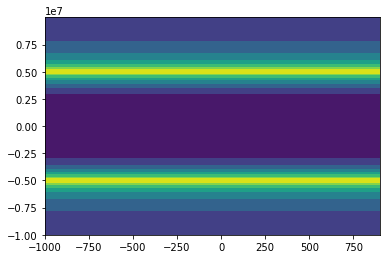

In [26]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**7,10**7,1000)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000000,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.999999999999**2),0.999999999999))
plt.contourf(xc,zc,gc)

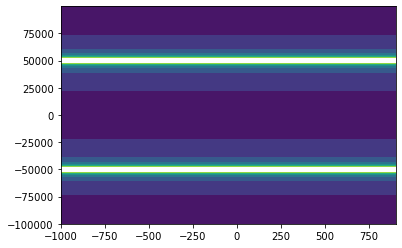

In [19]:
ds20 = -dt**2 + drho**2 + rho**22*dphi**2 + dz**2 +2*E/sym.sign(t-z)/(t-z)*(dt-dz)**2 \
++2*E/sym.sign(t+z)/(t+z)*(dt+dz)**2
g_33 = ds20.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,phi,z,E,v],g_33,"numpy")
zc = np.arange(-10**5,10**5,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-50000,xcg,zcg,1,0.99999999))
plt.contourf(xc,zc,gc,levels=np.arange(1.00,1.001,0.0001))

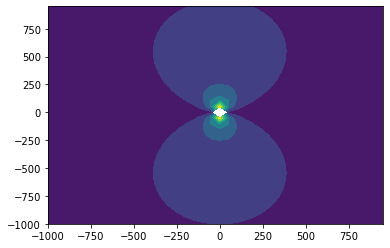

In [25]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([rho,phi,z,E],g_33.subs(t,0).subs(gamma,1).subs(v,0),"numpy")
zc = np.arange(-10**3,10**3,50)
xc = np.arange(-10**3,10**3,50)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(xcg,np.pi/2,zcg,1))
plt.contourf(xc,zc,gc)

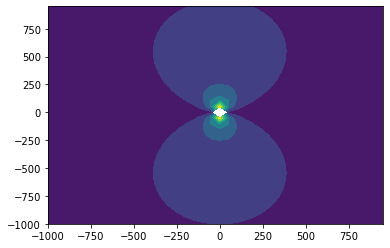

In [12]:
ds20 = -(1-2*E/(rho**2+z**2)**0.5)*dt**2+\
    (2*E/(rho**2+z**2)**0.5)/(1-2*E/(rho**2+z**2)**0.5)*\
    ((z*dz+rho*drho)/(rho**2+z**2)**0.5)**2+drho**2+rho**2*dphi**2+dz**2

g_33 = ds20.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)

g_33_func = sym.lambdify([rho,phi,z,E],g_33.subs(t,0).subs(gamma,1).subs(v,0),"numpy")
zc = np.arange(-10**3,10**3,50)
xc = np.arange(-10**3,10**3,50)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(xcg,np.pi/2,zcg,1))
plt.contourf(xc,zc,gc)

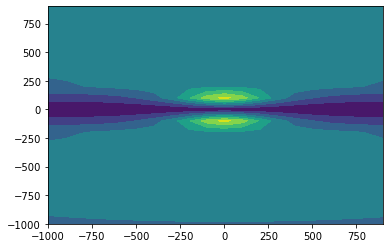

In [13]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**3,10**3,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-50,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.99**2),0.99))
plt.contourf(xc,zc,gc)

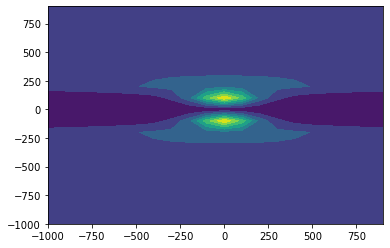

In [14]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**3,10**3,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-70,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.99**2),0.99))
plt.contourf(xc,zc,gc)

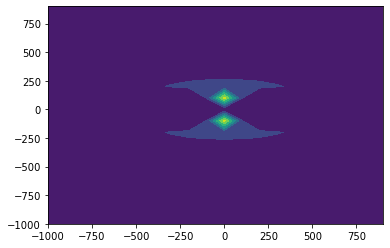

In [17]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**3,10**3,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-90,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.99**2),0.99))
plt.contourf(xc,zc,gc)

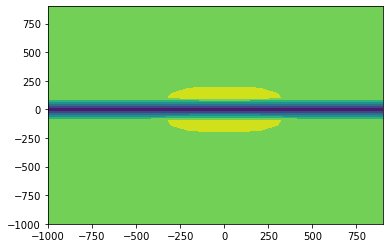

In [19]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**3,10**3,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-10,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.99**2),0.99))
plt.contourf(xc,zc,gc)

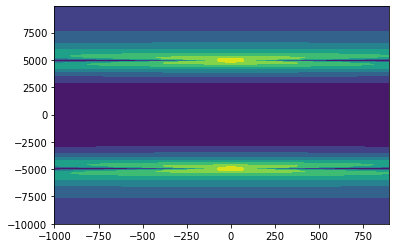

In [23]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**4,10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.99**2),0.99))
plt.contourf(xc,zc,gc)

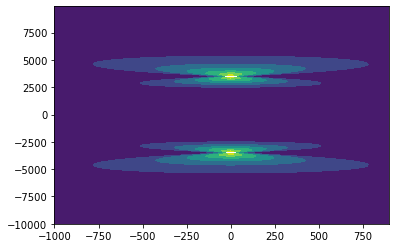

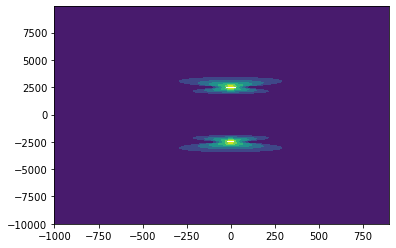

In [25]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**4,10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.50**2),0.50))
plt.contourf(xc,zc,gc)

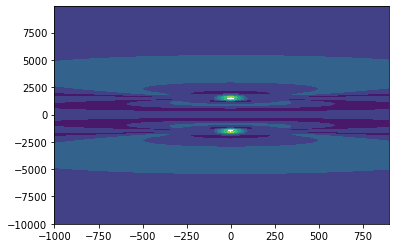

In [27]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
zc = np.arange(-10**4,10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,1,1/np.sqrt(1-0.30**2),0.30))
plt.contourf(xc,zc,gc)

<h1>Fitting Parameters</h1>

In [28]:
def fit_parameters(coords,params,cache={},dx=0.1,learning_rate=0.1):
    alphas = [np.random.random(),np.random.random(),np.random.random()+1]
    coords = [t,rho,phi,z]
    params = [E,gamma,v]
    g_uv = dill.load(open("g_uv_functions.p","rb"))
    inv_g_uv = dill.load(open("inv_g_uv_functions.p","rb"))
    for n in tqdm(range(10),leave=False):
        action = [0.,0.,0.,0.]
        points = np.zeros((10,7))
        points[:,:4] = np.random.random((10,4))
        points[:,0] = -5000 + 10000*points[:,0]
        points[:,1] = 1000*points[:,1]
        points[:,2] = np.pi*points[:,2]
        points[:,3] = -5000 + 10000*points[:,3]
        nans = np.array([1,1,1,1])
        for m in tqdm(range(4),leave=False):
            if m == 0:
                alpha, beta, Ef = alphas
            if m == 1:
                alpha, beta, Ef = alphas
                alpha += 0.1
            if m == 2:
                alpha, beta, Ef = alphas
                beta += 0.1
            if m == 3:
                alpha, beta, Ef = alphas
                Ef += 0.1
            points[:,4] = (1-Ef)/(1+2.72**(10*points[:,0]))/(1+2.72**((points[:,0]-alpha)/(beta)))+Ef
            points[:,5] = 1/sym.sqrt(1-0.99**2)/(1+2.72**(10*points[:,0]))/(1+2.72**((points[:,0]-alpha)/(beta)))+1
            points[:,6] =  0.99/(1+2.72**(10*points[:,0]))/(1+2.72**((points[:,0]-alpha)/(beta)))
            for k in tqdm(range(10),leave=False):
                    rtf, cache = ricci_tensor_function(list(points[k,:4]),list(points[k,4:]),cache)
                    test = float(np.sum(np.array(rtf)*np.array(inv_g_uv(*points[k])))*np.sqrt(abs(-np.linalg.det(g_uv(*points[k])))))
                    if  np.isnan(test):
                        nans[m]=0
                        print(rtf,inv_g_uv(*points[k]),np.sqrt(-np.linalg.det(g_uv(*points[k]))))
                    else:
                        action[m] += test
        alphas[0] += learning_rate*(action[0]-action[1])/dx*nans[0]*nans[1]
        alphas[1] += learning_rate*(action[0]-action[2])/dx*nans[0]*nans[2]
        alphas[2] += learning_rate*(action[0]-action[3])/dx*nans[0]*nans[3]
    return alphas

coords = [t,rho,phi,z]
params = [E,gamma,v]
cache = {'coords':coords, 'inv_g_uv':inv_g_uv,'params':params}
fit_parameters(coords, params, cache)

[0.12345301126603547, 0.9874242962466089, 1.623301074041426]

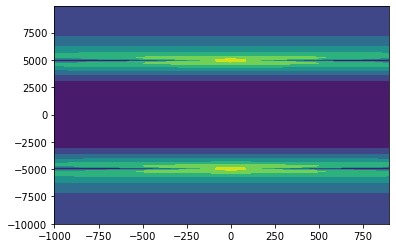

In [11]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
tc= -5000
alpha =0.12345301126603547
beta = 0.9874242962466089
Ef = 1.623301074041426
Efv = (1-Ef)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+Ef
gammav = 1/np.sqrt(1-0.99**2)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+1
vv =  0.99/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))
zc = np.arange(-10**4,10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,Efv,gammav,vv))
plt.contourf(xc,zc,gc)

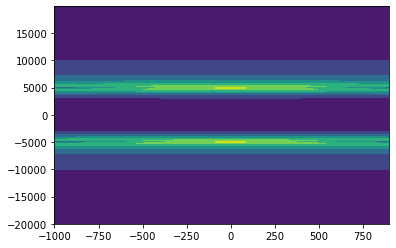

In [48]:

g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
tc= -100
alpha =0.12345301126603547
beta = 0.9874242962466089
Ef = 1.623301074041426
Efv = (1-Ef)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+Ef
gammav = 1/np.sqrt(1-0.99**2)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+1
vv =  0.99/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))
zc = np.arange(-2*10**4,2*10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,Efv,gammav,vv))
plt.contourf(xc,zc,gc)

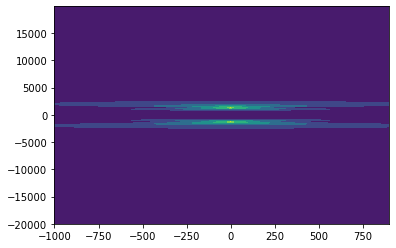

In [51]:
ds2 = -(1-2*E/sym.sqrt(rho0**2+z0**2))*dt0sqr**2+\
    (2*E/sym.sqrt(rho0**2+z0**2))/(1-2*E/sym.sqrt(rho0**2+z0**2))*\
    ((z0*dz0+rho0*drho0)/sym.sqrt(rho0**2+z0**2))**2+drho0**2+rho0**2*dphi**2+dz0**2
ds2 = ds2.subs(z0,sym.sqrt(2*zeta-rho**2))
ds2 = ds2.subs(dz0,sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho+sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)
ds2 = ds2.subs(dt0sqr,dt**2-dz**2\
    +(sym.diff(sym.sqrt(2*zeta-rho**2),t)*dt+sym.diff(sym.sqrt(2*zeta-rho**2),rho)*drho\
    +sym.diff(sym.sqrt(2*zeta-rho**2),z)*dz)**2)
ds2 = ds2.subs(rho0,rho)
ds2 = ds2.subs(drho0,drho)
g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
tc= 0
alpha =0.12345301126603547
beta = 0.9874242962466089
Ef = 1.623301074041426
Efv = (1-Ef)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+Ef
gammav = 1/np.sqrt(1-0.99**2)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+1
vv =  0.99/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))
zc = np.arange(-2*10**4,2*10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,Efv,gammav,vv))
plt.contourf(xc,zc,gc)

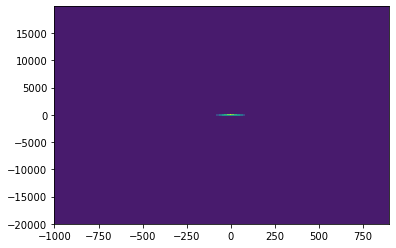

In [52]:

g_33 = ds2.subs(dt,0).subs(dphi,0).subs(drho,0).subs(dz,1)
g_33_func = sym.lambdify([t,rho,phi,z,E,gamma,v],g_33,"numpy")
tc= 5
alpha =0.12345301126603547
beta = 0.9874242962466089
Ef = 1.623301074041426
Efv = (1-Ef)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+Ef
gammav = 1/np.sqrt(1-0.99**2)/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))+1
vv =  0.99/(1+2.72**(10*tc))/(1+2.72**((tc-alpha)/(beta)))
zc = np.arange(-2*10**4,2*10**4,100)
xc = np.arange(-10**3,10**3,100)
xcg, zcg = np.meshgrid(xc, zc)
gc = abs(g_33_func(-5000,xcg,np.pi/2,zcg,Efv,gammav,vv))
plt.contourf(xc,zc,gc)

In [6]:
1.623301074041426/2

0.811650537020713

<h1>Dimensions of Collider</h1>

$1 km = 6.188 \times 10^{37} l_p$<br>
$3.333 \times 10^{-6} s = 6.188 \times 10^{37} t_p$<br>
$100,000  GeV/c^2 = 8.191 \times 10^{-15} E_p$<br>

<h1>Testing Einstein Tensor with Schwarzschild Metric</h1>

In [53]:
t, r, phi, theta, m, v, gamma = sym.symbols('t r phi theta m v gamma')

coords = [t,r,phi,theta]
g_uv = sym.Matrix([[-(1-2*m/r),0,0,0],[0,1/(1-2*m/r),0,0],[0,0,r**2*sym.sin(theta)**2,0],[0,0,0,r**2]])
sym.simplify(einstein_tensor(coords,g_uv)[0])

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])